#### From the IBL database, get data on weight and trial counts under different water regimes at CSHL
Anne Urai, CSHL, 2019

In [1]:
# PYTHON STARTS BY IMPORTING 'MODULES' AND 'PACKAGES' THAT WE'LL USE LATER

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# set a path where you want figures to be saved
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')


Connecting anneurai@datajoint.internationalbrainlab.org:3306


If your login to DataJoint was successful, you should see something like 

'Connecting youruser@datajoint.internationalbrainlab.org:3306'

In [2]:
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 6)



In [3]:
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)

# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# total_water_date = dj.U('subject_uuid', 'session_date').aggr(
#     water_with_date, 
#     total_water='SUM(water_administered)', 
#     watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
#     adlib='MAX(adlib)') & 'session_date > "2019-03-17"'

# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()

# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = subj * session_with_date * avg_weight_date * total_water_date

df = pd.DataFrame(b.fetch(as_dict=True))
df.tail(n=10)



# # TODO: updated code from Shan and Dimitri
# weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib', 
#     session_date='DATE(administration_time)')
# total_water_date = dj.U('subject_uuid', 'session_date').aggr(
#     water_with_date, 
#     total_water='SUM(water_administered)', 
#     watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
#     adlib='MAX(adlib)') & 'session_date > "2019-05-01"'

# # get session with date
# session_with_date = behavior.TrialSet.proj(
#     'n_trials', session_date='DATE(session_start_time)') & 'session_date > "2019-05-01"'

# # Here you can get the all info including total water, adlib, average weight, and number of sessions per day
# water_session =  total_water_date.aggr(session_with_date, n_sessions="count(n_trials)", keep_all_rows=True) * total_water_date
# water_weight_session = water_session.aggr(weight_with_date, avg_weight='AVG(weight)', keep_all_rows=True) * water_session

,subject_uuid,session_start_time,session_date,subject_nickname,sex,n_trials,performance,performance_easy,signed_contrasts,n_trials_stim,n_trials_stim_right,prob_choose_right,threshold,bias,lapse_low,lapse_high,avg_weight,total_water,watertype,adlib
661,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-08-26 15:04:11,2019-08-26,IBL_10,M,148,0.601351,0.785714,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[22, 6, 14, 11, 18, 23, 16, 18, 20]","[7, 1, 7, 8, 7, 15, 9, 14, 18]","[0.3181818181818182, 0.16666666666666666, 0.5,...",38.701000,7.401490,3.084300e-01,9.870760e-02,26.320000,0.267,Water 10% Sucrose,0
662,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-08-29 12:57:51,2019-08-29,IBL_10,M,72,0.458333,0.692308,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[7, 9, 14, 10, 5, 6, 8, 7, 6]","[2, 3, 4, 2, 0, 5, 5, 5, 5]","[0.2857142857142857, 0.3333333333333333, 0.285...",0.479241,3.660910,2.444440e-01,2.592590e-01,24.430000,0.186,Water 10% Sucrose,0
663,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-08-29 14:06:31,2019-08-29,IBL_10,M,64,0.453125,0.692308,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[9, 7, 7, 6, 10, 7, 6, 8, 4]","[2, 3, 2, 2, 2, 2, 2, 6, 2]","[0.2222222222222222, 0.42857142857142855, 0.28...",0.720299,13.068700,2.826090e-01,3.333330e-01,24.430000,0.186,Water 10% Sucrose,0
664,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-08-30 12:36:12,2019-08-30,IBL_10,M,613,0.892333,0.984000,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[62, 76, 69, 66, 62, 76, 68, 71, 63]","[2, 1, 5, 14, 30, 65, 64, 69, 63]","[0.03225806451612903, 0.013157894736842105, 0....",9.839330,-0.371445,2.309300e-02,1.572900e-02,24.150000,1.641,Water 10% Sucrose,0
665,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-09-03 14:29:43,2019-09-03,IBL_10,M,661,0.880484,0.959064,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[71, 65, 67, 68, 61, 77, 69, 83, 100]","[5, 3, 10, 16, 33, 64, 68, 76, 98]","[0.07042253521126761, 0.046153846153846156, 0....",9.091450,-0.877664,7.138550e-02,3.974610e-02,25.430000,1.746,Water 10% Sucrose,0
666,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-09-04 14:24:30,2019-09-04,IBL_10,M,615,0.913821,0.992958,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[67, 61, 60, 53, 67, 83, 77, 72, 75]","[0, 1, 3, 10, 29, 73, 73, 71, 74]","[0.0, 0.01639344262295082, 0.05, 0.18867924528...",9.122120,-0.174939,9.159140e-03,1.465150e-02,25.510000,1.686,Water 10% Sucrose,0
667,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-09-05 15:22:01,2019-09-05,IBL_10,M,547,0.893967,0.982143,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[65, 69, 79, 47, 75, 65, 46, 54, 47]","[2, 5, 5, 8, 43, 57, 44, 53, 47]","[0.03076923076923077, 0.07246376811594203, 0.0...",7.999540,-0.490274,4.999380e-02,1.453120e-02,25.260000,1.467,Water 10% Sucrose,0
668,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-09-06 14:36:30,2019-09-06,IBL_10,M,701,0.860200,0.956522,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[84, 79, 67, 76, 76, 79, 79, 84, 77]","[7, 8, 11, 28, 55, 71, 75, 84, 77]","[0.08333333333333333, 0.10126582278481013, 0.1...",11.379000,-2.802750,8.652860e-02,3.232890e-09,24.840000,1.809,Water 10% Sucrose,0
669,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-09-09 13:54:57,2019-09-09,IBL_10,M,472,0.843220,1.000000,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[53, 66, 55, 44, 47, 51, 50, 52, 54]","[0, 1, 8, 8, 21, 33, 43, 48, 54]","[0.0, 0.015151515151515152, 0.1454545454545454...",17.021900,0.521579,7.781680e-12,1.740430e-02,27.590000,1.194,Water 10% Sucrose,0
670,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2019-09-10 09:37:52,2019-09-10,IBL_10,M,378,0.841270,0.977778,"[-1.0, -0.25, -0.125, -0.0625, 0.0, 0.0625, 0....","[40, 38, 39, 44, 34, 37, 41, 55, 50]","[0, 4, 2, 8, 17, 20, 32, 49, 48]","[0.0, 0.10526315789473684, 0.05128205128205128...",15.317300,3.343860,3.822910e-02,5.971120e-02,26.440001,0.954,Water 10% Sucrose,0


In [4]:
# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
                27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W', 34:'W', 36:'H'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))
sanitycheck

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


week_number  condition  session_date  weekday_name
12           C          2019-03-18    Monday                                        [Water 10% Sucrose]
                        2019-03-19    Tuesday                                       [Water 10% Sucrose]
                        2019-03-20    Wednesday                                     [Water 10% Sucrose]
                        2019-03-21    Thursday                                      [Water 10% Sucrose]
                        2019-03-22    Friday          [Water 10% Sucrose; Water 2% Citric Acid, Wate...
                                                                            ...                        
34           W          2019-08-22    Thursday                                      [Water 10% Sucrose]
36           H          2019-09-03    Tuesday                                       [Water 10% Sucrose]
                        2019-09-04    Wednesday                                     [Water 10% Sucrose]
             

In [5]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(60)

/anaconda3/envs/djenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


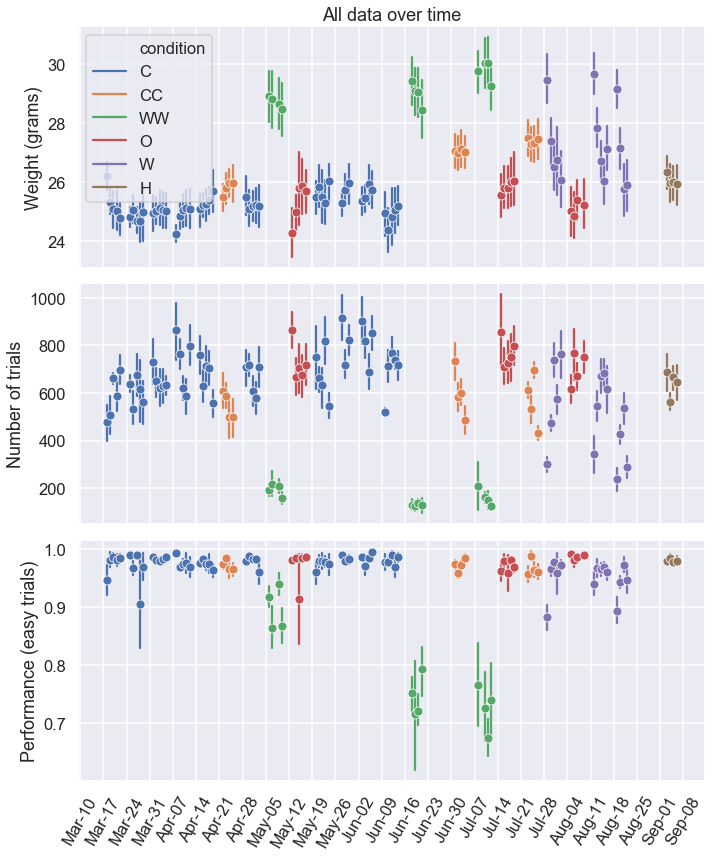

In [6]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(10, 12))
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=0, data=df, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials", xlabel="")
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[2], legend=False)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")

# set grid to show Mondays
fix_date_axis(ax[2])
ax[0].set_title('All data over time')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_over_time.pdf"))

Now that we have our data, let's visualize it!

The plot above shows an example of using seaborn (https://seaborn.pydata.org/index.html), see the documentation for many other types of plots you can make. 

Try to make this plot a bit nicer, by doing the following:
1. move the legend to the right of the plot, or make it smaller so it doesn't obscure the datapoints. you can also rotate the 'tickmarks' (dates) on the x-axis to make them more readable.
- make an additional column with the day of the week

2. play with the arguments to 'lineplot' - see e.g. what happens when linewidth=1, or ci=95
3. instead of marking each day by its water condition _that day_, change the dataframe to label it with the condition of _that week_ (so that e.g. a week with only 10% sucrose water, but _preceded_ by a 2% CA weekend is different from a week with 10% sucrose water, but _preceded by a regular water weekend). this should then indicate the color
4. check in Alyx that all mice on a given day have the same 'condition'. Also make sure there are data logged for each day, including the weekend.
4. repeat the plot for individual mice (hint: seaborn's FacetGrid)


Of these, 3 and 4 are the most important: the rest is 

Once this looks good, try to create a new plot that ignores the date, and plots all datapoints (weight and nr of trials) from one condition (weekend + week water regime) in one overview - as on the SfN poster. You can use e.g. seaborn's catplot to make it look nice.

Other todo (for Anne):
1. indicate Mondays 


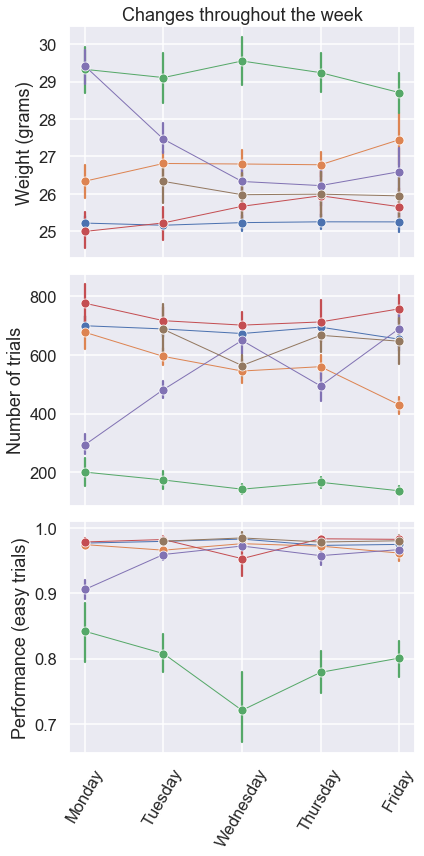

In [7]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=1, data=df, ax=ax[0], legend=False)
ax[0].set(ylabel="Weight (grams)")
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials")
sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[2], legend=False)
ax[2].set(ylabel="Performance (easy trials)", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="")

for item in ax[2].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Changes throughout the week')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_within_week.pdf"))

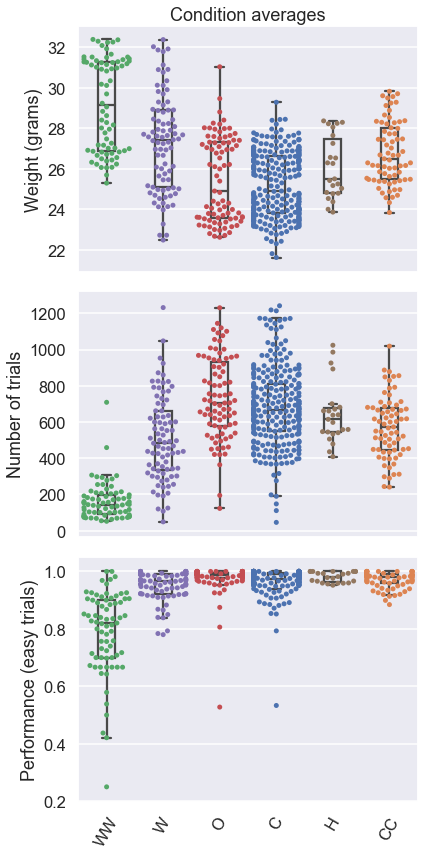

In [9]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))
condition_order = ["WW", "W", "O", "C", "H", "CC"]

sns.swarmplot(x="condition", y="avg_weight", order=condition_order, hue="condition", data=df, ax=ax[0])
sns.boxplot(x="condition", y="avg_weight", order=condition_order, data=df, fliersize=0, ax=ax[0], boxprops={'facecolor':'None'}, width=.3)
ax[0].set(ylabel="Weight (grams)", xlabel="")
ax[0].get_legend().remove()

sns.swarmplot(x="condition", y="n_trials", order=condition_order, hue="condition", data=df, ax=ax[1])
sns.boxplot(x="condition", y="n_trials", order=condition_order, data=df, fliersize=0, ax=ax[1], boxprops={'facecolor':'None'}, width=.3)
ax[1].set(ylabel="Number of trials", xlabel="")
ax[1].get_legend().remove()

sns.swarmplot(x="condition", y="performance_easy", order=condition_order, hue="condition", data=df, ax=ax[2])
sns.boxplot(x="condition", y="performance_easy", order=condition_order, data=df, fliersize=0, ax=ax[2], boxprops={'facecolor':'None'}, width=.3)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")
ax[2].get_legend().remove()

for item in ax[2].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Condition averages')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_stats.pdf"))

In [10]:
# NOW DO STATS ON THE TRIAL COUNTS
import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("n_trials ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

IndexError: index 613 is out of bounds for axis 0 with size 613

In [11]:
md = smf.mixedlm("avg_weight ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

IndexError: index 613 is out of bounds for axis 0 with size 613